In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [4]:
csvFile = 'HW/Extension1.xlsx'
df = pd.read_excel(csvFile, engine='openpyxl',)
df.head()

,question,answer
0,چگونه می توان از موفقیت آمیز بودن خرید اینترنت...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
1,چگونه باید از موفقیت آمیز بودن خرید اینترنتی ه...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
2,از چه راهی باید وضعیت خرید اینترنتی را مشاهده ...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
3,روشی که می‌توان مطمئن شد خرید اینترنتی به درست...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...
4,برای این‌که مطمئن بشیم که خرید اینترنتی به درس...,پس ‎‎‎‎‎‎‎‎‎‎‎‎‎از انجام خرید سیم کارت از طریق...


In [23]:
labels = {} 
counter = 0
for count in range(len(df.answer)):
    if df.answer[count] == df.answer[count]:
        if df.answer[count] not in labels.values(): 
            labels[counter] = df.answer[count]
            counter +=1
        df.answer[count] = counter
    
df = df.dropna()

<AxesSubplot:xlabel='answer'>

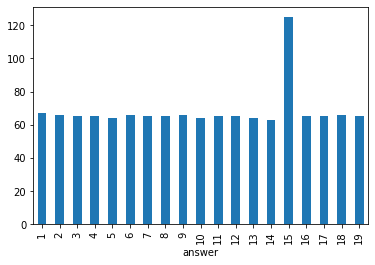

In [24]:
df.groupby(['answer']).size().plot.bar()

##Dataset Class

Now that we know what kind of output that we will get from BertTokenizer , let’s build a Dataset class for our news dataset that will serve as a class to generate our news data.

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'positive':1,
#           'negative':0,
#           }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label-1] for label in df['answer']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['question']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

in the above implementation, we define a variable called labels , which is a dictionary that maps the category in the dataframe into the id representation of our label. Notice that we also call BertTokenizer in the __init__ function above to transform our input texts into the format that BERT expects.


##Model Building

So far, we have built a dataset class to generate our data. Now let’s build the actual model using a pre-trained BERT base model which has 12 layers of Transformer encoder.

If your dataset is not in English, it would be best if you use bert-base-multilingual-cased model. If your data is in German, Dutch, Chinese, Japanese, or Finnish, you can use the model pre-trained specifically in these languages.

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

As you can see from the code above, BERT model outputs two variables:

The first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.

The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.

We then pass the pooled_output variable into a linear layer with ReLU activation function. At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels (sport, business, politics, entertainment, and tech).

##Training Loop

Now it’s time for us to train the model. The training loop will be a standard PyTorch training loop.

In [11]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

##Evaluate Model on Test Data

Now that we have trained the model, we can use the test data to evaluate the model’s performance on unseen data. Below is the function to evaluate the performance of the model on the test set.

In [12]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


After defining dataset class, let’s split our dataframe into training, validation, and test set with the proportion of 80:10:10.

In [32]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1036 130 130


We train the model for 5 epochs and we use Adam as the optimizer, while the learning rate is set to 1e-6. We also need to use categorical cross entropy as our loss function since we’re dealing with multi-class classification.

In [36]:
from_tf=True
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
evaluate(model, df_test)